In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
import random
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap

In [2]:
#setting a seed to ensure reproducibility

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
data = pd.read_csv("simulated_symptom_data.csv")

symptom_data = data.drop(columns=['Age', 'SymptomCount_T1', 'FullPersistence']) #columns for L-VAE

#split dataset into t1 and t2

df_t1 = symptom_data.iloc[:, :12]  #symptoms at timepoint 1
df_t2 = symptom_data.iloc[:, 12:]  #symptoms at timepoint 2

In [4]:
#splitting data into dataframes based on time points
symptom_data_t2_cols = [col for col in symptom_data.columns if col.endswith("_T2")]
symptom_data_t1_cols = [col.replace("_T2", "") for col in symptom_data_t2_cols]

#converting data frames to tensors for L-VAE
X_t1 = torch.tensor(symptom_data[symptom_data_t1_cols].T.values, dtype=torch.float32)  #shape: [n_symptoms, n_individuals]
X_t2 = torch.tensor(symptom_data[symptom_data_t2_cols].T.values, dtype=torch.float32)

In [5]:
#combine tensors of both timepoints into one stack
X = torch.stack([X_t1, X_t2], dim=1)
print(X.shape)

torch.Size([12, 2, 9166])


In [6]:
#hyperparameters for L-VAE model
input_size = X.shape[2] #the input size is the number of individuals- which is the 3rd element in X
latent_dim = 2 #how many dimensions the model reduces inputs to(2d plot)
hidden_dim = 32 #size of hidden layer in neural network- balanced to avoid risk of overfitting
batch_size = 4 #number of samples processed simultaneously during each training step
epochs = 100 #number of passes through training dataset- too many causes overfitting
lr = 0.001 #learning rate- 0.001 is a standard value

In [7]:
#L-VAE model

#encoder neural network- time series which outputs two vectors mu and log-variance
class TemporalEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, latent_dim):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_dim, batch_first=True) #Gated Recurrent Unit- neural network which models temporal dependencies
        self.mu = nn.Linear(hidden_dim, latent_dim) #mu = mean of latent space
        self.logvar = nn.Linear(hidden_dim, latent_dim) #log-variance of latent space   
#mapping final hidden state to mean and log-variance of latent space

#takes input sequence x into hidden layer, computes mean and log-variance from final hidden state
    def forward(self, x):
        h_seq, _ = self.rnn(x)
        h_last = h_seq[:, -1, :]
        return self.mu(h_last), self.logvar(h_last)

#decoder neural network- reconstructs a full sequence from the latent vector produced by the encoder
class TemporalDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_size):
        super().__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
#transforming latent vector into a hidden state
    
    def forward(self, z, seq_len):
        h = torch.relu(self.fc(z))
        out = self.out(h).unsqueeze(1).repeat(1, seq_len, 1)
        return out

#combines the defined encoder and decoder to define the L-VAE model
class LongitudinalVAE(nn.Module):
    def __init__(self, input_size, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = TemporalEncoder(input_size, hidden_dim, latent_dim)
        self.decoder = TemporalDecoder(latent_dim, hidden_dim, input_size)

    def reparameterize(self, mu, logvar): #allows gradients to backpropagate
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z, x.size(1))
        return recon, mu, logvar

def lvae_loss(recon, x, mu, logvar): #defines the loss function for training the L-VAE
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

#training L-VAE
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LongitudinalVAE(input_size, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = lvae_loss(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

Epoch 1, Loss: 83228.58
Epoch 2, Loss: 66243.43
Epoch 3, Loss: 66936.14
Epoch 4, Loss: 63396.15
Epoch 5, Loss: 61500.84
Epoch 6, Loss: 61477.68
Epoch 7, Loss: 61046.11
Epoch 8, Loss: 59403.42
Epoch 9, Loss: 59120.07
Epoch 10, Loss: 57414.00
Epoch 11, Loss: 56456.44
Epoch 12, Loss: 55630.82
Epoch 13, Loss: 56002.67
Epoch 14, Loss: 54490.69
Epoch 15, Loss: 53793.66
Epoch 16, Loss: 52468.09
Epoch 17, Loss: 52247.46
Epoch 18, Loss: 51191.80
Epoch 19, Loss: 50809.62
Epoch 20, Loss: 49953.81
Epoch 21, Loss: 49880.65
Epoch 22, Loss: 49625.72
Epoch 23, Loss: 48186.02
Epoch 24, Loss: 46597.62
Epoch 25, Loss: 46226.40
Epoch 26, Loss: 46730.09
Epoch 27, Loss: 45510.72
Epoch 28, Loss: 43857.65
Epoch 29, Loss: 44671.89
Epoch 30, Loss: 42887.78
Epoch 31, Loss: 41218.79
Epoch 32, Loss: 42283.95
Epoch 33, Loss: 41585.26
Epoch 34, Loss: 40027.93
Epoch 35, Loss: 39291.23
Epoch 36, Loss: 40264.55
Epoch 37, Loss: 37804.85
Epoch 38, Loss: 37654.02
Epoch 39, Loss: 36988.96
Epoch 40, Loss: 37606.72
Epoch 41,

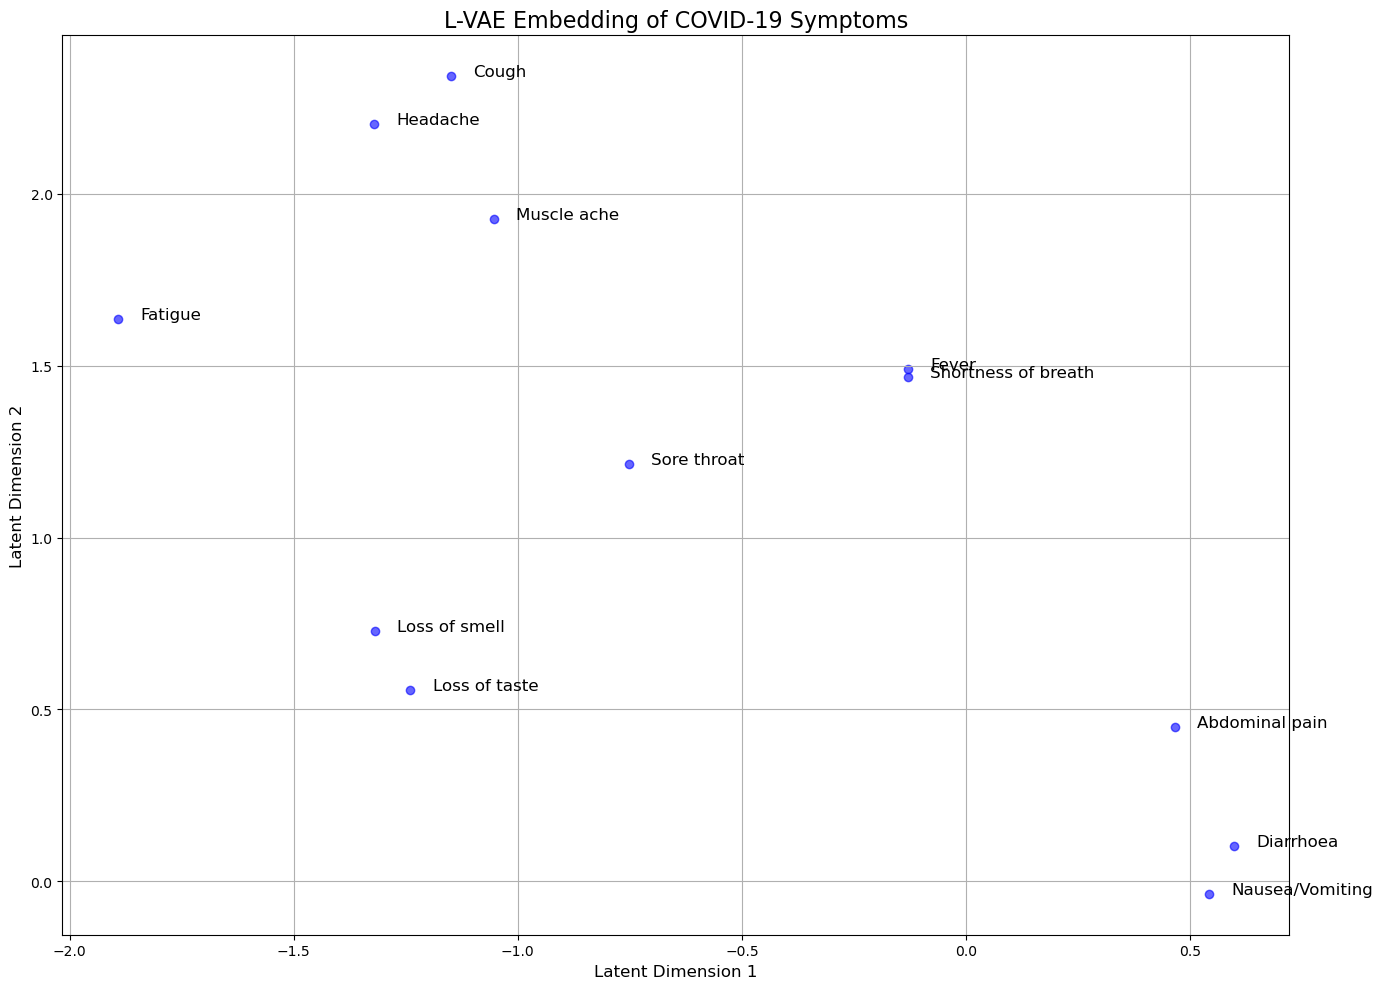

In [8]:
#2d plot of L-VAE embeddings

model.eval()
with torch.no_grad():
    mu_symptoms, _ = model.encoder(X)

symptom_labels = [col for col in symptom_data_t1_cols]

plt.figure(figsize=(14, 10))
plt.scatter(mu_symptoms[:, 0], mu_symptoms[:, 1], c='blue', alpha=0.6)
for i, label in enumerate(symptom_labels):
    plt.text(mu_symptoms[i, 0]+0.05, mu_symptoms[i, 1], label, fontsize=12)

plt.title("L-VAE Embedding of COVID-19 Symptoms", fontsize=16)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

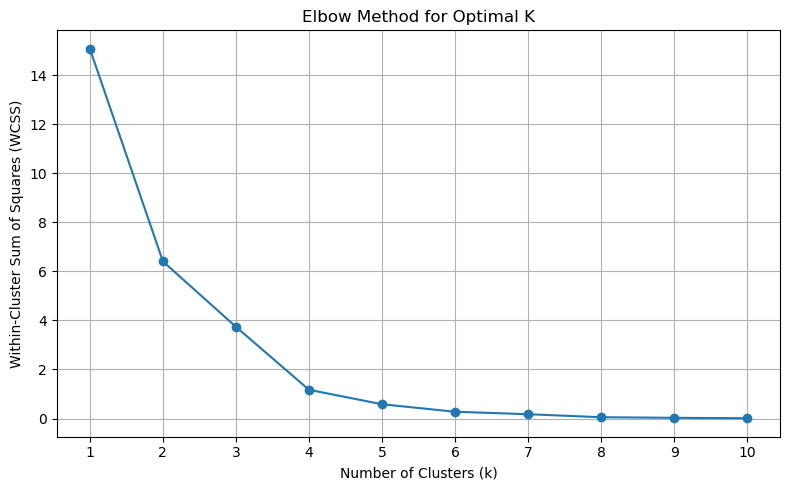

In [9]:
#define the range of k values to try for elbow plot
k_values = range(1, 11)
wcss = []  #within-cluster sum of squares

#compute WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(mu_symptoms)  #mu_symptoms is L-VAE latent space
    wcss.append(kmeans.inertia_)  #inertia_ gives the WCSS

#elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

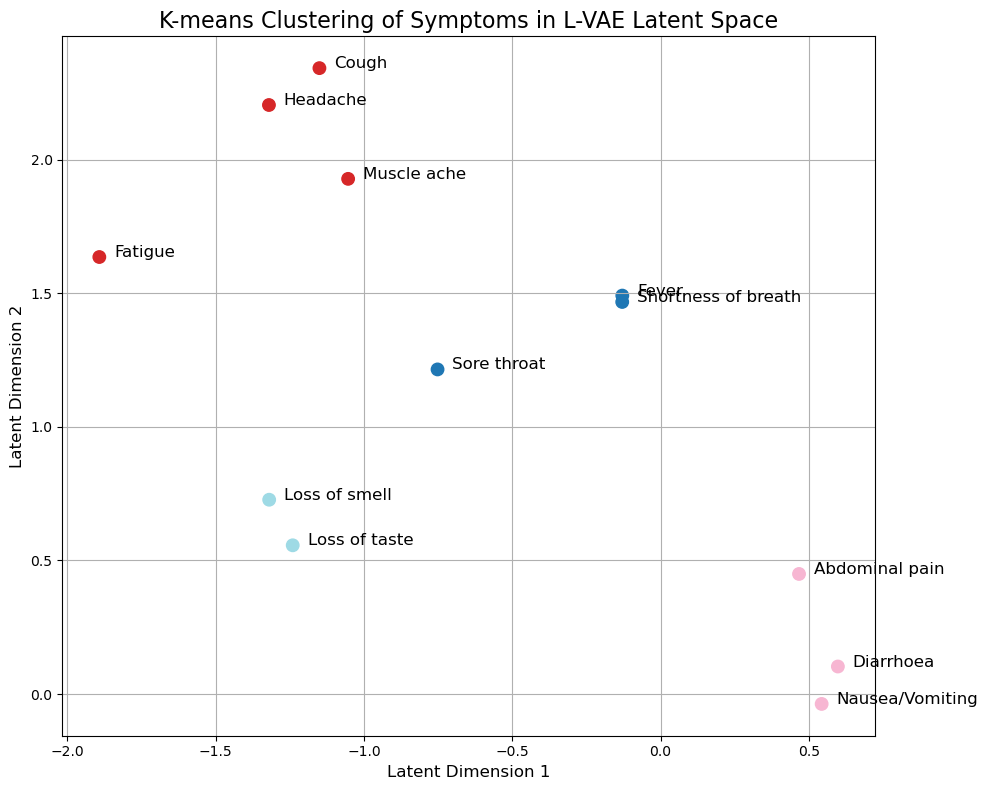

In [10]:
#K-means clustering
n_clusters = 4  #adjust this based on elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(mu_symptoms)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    mu_symptoms[:, 0],
    mu_symptoms[:, 1],
    c=labels,
    cmap='tab20',
    s=80,
)

for i, label in enumerate(symptom_labels):
    plt.text(mu_symptoms[i, 0] + 0.05, mu_symptoms[i, 1], label, fontsize=12)

plt.title("K-means Clustering of Symptoms in L-VAE Latent Space", fontsize=16)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#shifting labels so there is no cluster 0
labels=labels+1

symptom_clusters = pd.DataFrame({
    'Symptom': symptom_labels,
    'Cluster': labels
})

symptom_clusters = symptom_clusters.sort_values(by='Cluster').reset_index(drop=True)

print(symptom_clusters)

                Symptom  Cluster
0                 Fever        1
1           Sore throat        1
2   Shortness of breath        1
3           Muscle ache        2
4               Fatigue        2
5                 Cough        2
6              Headache        2
7       Nausea/Vomiting        3
8        Abdominal pain        3
9             Diarrhoea        3
10        Loss of taste        4
11        Loss of smell        4


In [12]:
#silhouette score
score = silhouette_score(mu_symptoms, labels)

print(f"Silhouette Score (k={n_clusters}): {score:.3f}")

Silhouette Score (k=4): 0.622


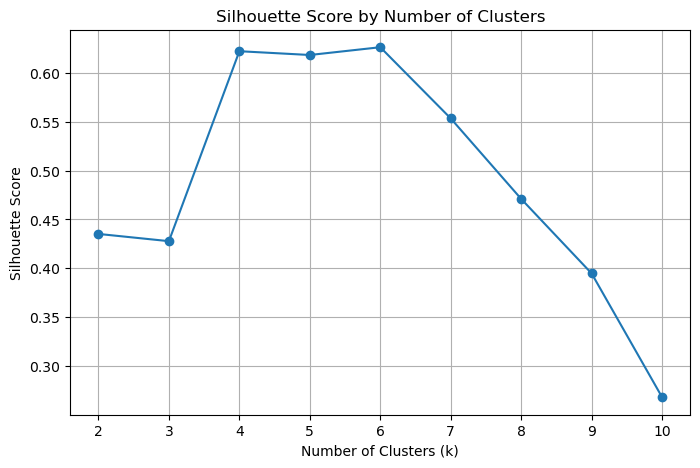

In [13]:
scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(mu_symptoms)
    score = silhouette_score(mu_symptoms, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [14]:
#setting a seed to ensure reproducibility again

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
#VAE for comparison with L-VAE

#stack the transposes of t1 and t2
X_t1 = symptom_data[symptom_data_t1_cols].T.values
X_t2 = symptom_data[symptom_data_t2_cols].T.values

#convert to tensor
X_symptoms = torch.tensor(np.hstack([X_t1, X_t2]), dtype=torch.float32) #shape= [n_symptoms, 2 * n_individuals]

In [16]:
#hyperparameters for VAE
input_dim = X_symptoms.shape[1]  #input dimension is number of individuals multiplied by 2(each individual at each timepoint)
latent_dim = 2 #how many dimensions the model reduces inputs to(2d plot)
hidden_dim = 32 #size of hidden layer in neural network- balanced to avoid risk of overfitting
batch_size = 4 #number of samples processed simultaneously during each training step
epochs = 100 #number of passes through training dataset- too many causes overfitting
lr = 0.001 #learning rate- 0.001 is a standard value

In [17]:
#defining Variational Autoencoder class
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential( #encoder network maps input data to hidden representation
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU() #non-linear activation function
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential( #decoder network: maps latent space to reconstructed input
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim), #output layer
            nn.Sigmoid() #outputs are [0, 1] for binary or scaled inputs
        )

    def reparameterize(self, mu, logvar): #reparameterisation trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x): #forward pass: encode -> sample -> decode
        h = self.encoder(x) #encode input to hidden features
        mu = self.mu(h) #mean of latent distribution
        logvar = self.logvar(h) #log-variance of latent distribution
        z = self.reparameterize(mu, logvar) #sample latent vector using reparameterisation
        recon = self.decoder(z) #decode latent vector back to reconstruction
        return recon, mu, logvar #return reconstruction, mean and log-variance

#loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') #reconstruction loss measures how well output matches original input
    #binary cross-entropy used because data is binary
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL divergence regularises latent space to follow N(0, 1)
    return recon_loss + kld

In [18]:
#training model

dataset = TensorDataset(X_symptoms)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #dataloader batches and shuffles dataset

vae = VAE(input_dim, hidden_dim, latent_dim) #initialise VAE model
optimizer = optim.Adam(vae.parameters(), lr=lr) #Adam optimiser used

for epoch in range(epochs): #training loop
    vae.train()
    total_loss = 0
    for batch in loader:
        x_batch = batch[0] #select batch
        optimizer.zero_grad() #reset gradient
        recon, mu, logvar = vae(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar) #compute loss
        loss.backward() #backpropogation
        optimizer.step() #update weights
        total_loss += loss.item() #accumulate loss from batch
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


#extracting embedding
vae.eval()
with torch.no_grad():
    _, mu_symptoms, _ = vae(X_symptoms) #encode symptoms to latent space(mu)

Epoch 1, Loss: 155324.93
Epoch 2, Loss: 155786.01
Epoch 3, Loss: 155474.30
Epoch 4, Loss: 151516.31
Epoch 5, Loss: 151140.59
Epoch 6, Loss: 149774.97
Epoch 7, Loss: 148853.71
Epoch 8, Loss: 147556.50
Epoch 9, Loss: 145968.95
Epoch 10, Loss: 144388.15
Epoch 11, Loss: 142809.49
Epoch 12, Loss: 139321.88
Epoch 13, Loss: 136208.57
Epoch 14, Loss: 131370.83
Epoch 15, Loss: 127563.20
Epoch 16, Loss: 123633.67
Epoch 17, Loss: 119940.27
Epoch 18, Loss: 115857.52
Epoch 19, Loss: 113082.39
Epoch 20, Loss: 109638.80
Epoch 21, Loss: 107893.60
Epoch 22, Loss: 104998.94
Epoch 23, Loss: 107577.38
Epoch 24, Loss: 103845.28
Epoch 25, Loss: 102670.34
Epoch 26, Loss: 99107.31
Epoch 27, Loss: 98396.12
Epoch 28, Loss: 96470.55
Epoch 29, Loss: 95800.77
Epoch 30, Loss: 94026.20
Epoch 31, Loss: 92851.36
Epoch 32, Loss: 91919.59
Epoch 33, Loss: 90497.52
Epoch 34, Loss: 89324.92
Epoch 35, Loss: 88317.72
Epoch 36, Loss: 87367.59
Epoch 37, Loss: 86308.59
Epoch 38, Loss: 85132.62
Epoch 39, Loss: 84055.54
Epoch 40,

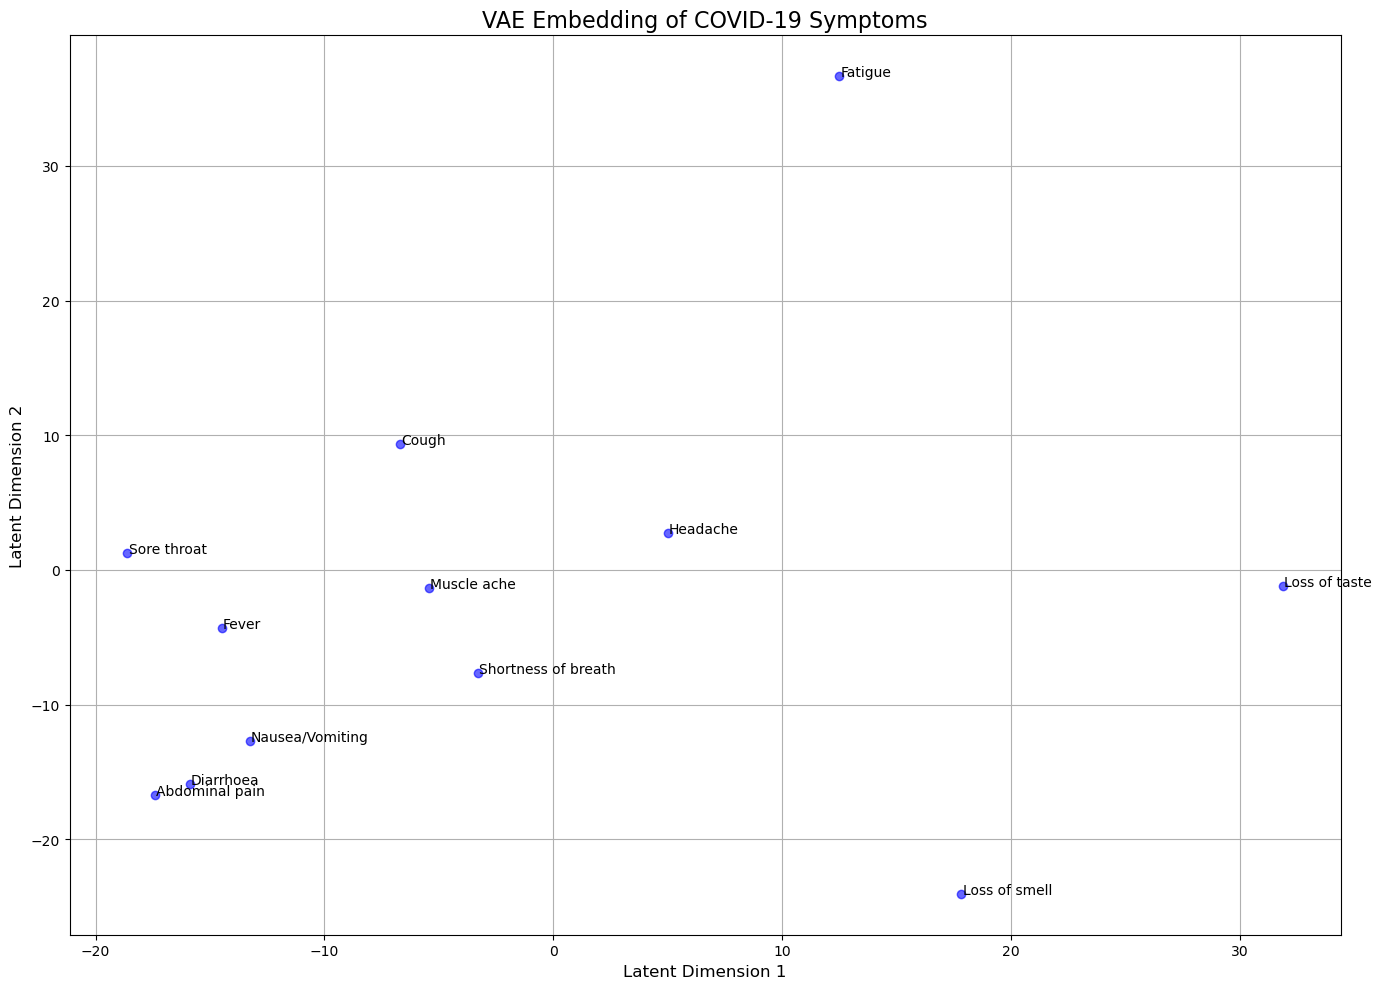

In [19]:
#plotting VAE embeddings

symptom_labels = symptom_data_t1_cols

plt.figure(figsize=(14, 10))
plt.scatter(mu_symptoms[:, 0], mu_symptoms[:, 1], c='blue', alpha=0.6)
for i, label in enumerate(symptom_labels):
    plt.text(mu_symptoms[i, 0] + 0.05, mu_symptoms[i, 1], label, fontsize=10)

plt.title("VAE Embedding of COVID-19 Symptoms", fontsize=16)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


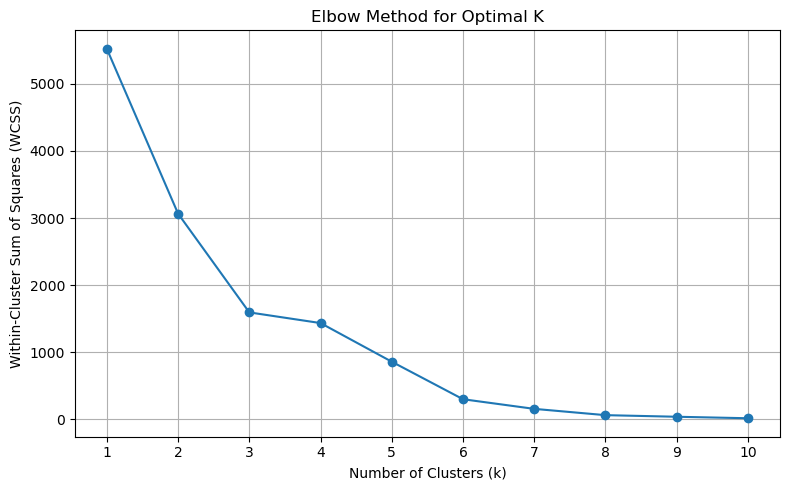

In [20]:
#define the range of k values to try for elbow plot
k_values = range(1, 11)
wcss = []  #within-cluster sum of squares

#compute WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(mu_symptoms)  # mu_symptoms is L-VAE latent space
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS

#plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

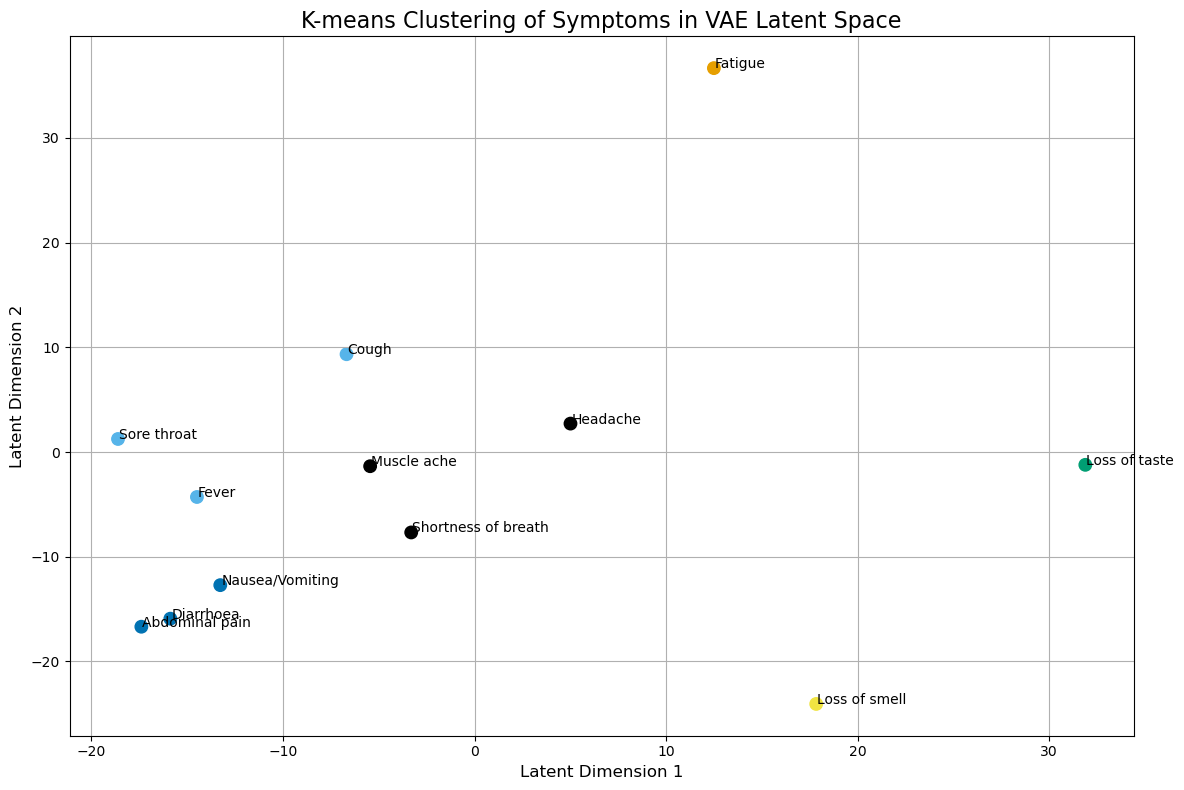

In [21]:
#k-means clustering

n_clusters = 6  #select based on elbow plot
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(mu_symptoms)

colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
cmap = ListedColormap(colors)

#plot embeddings coloured by clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    mu_symptoms[:, 0],
    mu_symptoms[:, 1],
    c=labels,
    cmap=cmap,
    s=80
)

#add symptom labels
for i, label in enumerate(symptom_labels):
    plt.text(
        mu_symptoms[i, 0].item() + 0.05,
        mu_symptoms[i, 1].item(),
        label,
        fontsize=10
    )

plt.title("K-means Clustering of Symptoms in VAE Latent Space", fontsize=16)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
#shift cluster labels to start from 1 instead of 0
labels = labels + 1

symptom_clusters = pd.DataFrame({
    'Symptom': symptom_labels,
    'Cluster': labels
})

symptom_clusters = symptom_clusters.sort_values(by='Cluster').reset_index(drop=True)

print(symptom_clusters)


                Symptom  Cluster
0           Muscle ache        1
1   Shortness of breath        1
2              Headache        1
3               Fatigue        2
4                 Fever        3
5           Sore throat        3
6                 Cough        3
7         Loss of taste        4
8         Loss of smell        5
9       Nausea/Vomiting        6
10       Abdominal pain        6
11            Diarrhoea        6


In [23]:
#silhouette score
score = silhouette_score(mu_symptoms, labels)

print(f"Silhouette Score (k={n_clusters}): {score:.3f}")

Silhouette Score (k=6): 0.288


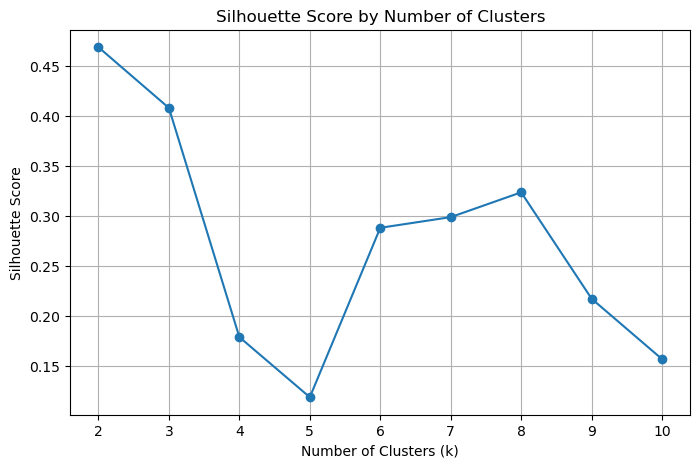

In [24]:
scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(mu_symptoms)
    score = silhouette_score(mu_symptoms, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
